# Import dependencies

In [6]:
import pandas as pd
import numpy as np
import json
import io
import datetime as dt
import string
import unicodedata

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')

import spacy
import en_core_web_sm
# pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.0.0/en_core_web_sm-2.0.0.tar.gz
nlp = en_core_web_sm.load()
# nlp = spacy.load('en_core', parse=True, tag=True, entity=True)

import re
from bs4 import BeautifulSoup


from gensim import corpora, models, similarities

import matplotlib.pyplot as plt
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, #entity=True)

# Read in data

In [7]:
#create dataframe from input data; identify the column with the tweet text
tweets=pd.read_csv('Tweets.csv')
print('Number of observations are: '+str(len(tweets)))

Number of observations are: 14640


In [8]:
#remove any rows that has no tweet text
df=tweets.text.dropna()
df = df.reset_index(drop=True)
print('Number of observations are: '+str(len(df)))

Number of observations are: 14640


In [9]:
#Create dictionary of all tweets
tweet_dictionary = {}
i = 0
for line in df:
        tweet_dictionary[i] = line.lower()
        i += 1
print(tweet_dictionary[1])

@virginamerica plus you've added commercials to the experience... tacky.


# Data Preprocessing for Sentiment Analysis

Remove HTML Links

In [10]:
def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

In [11]:
for i in range(0,len(tweet_dictionary)):
    tweet_dictionary[i]=strip_links(tweet_dictionary[i])

Expand contractions

In [12]:
#code source is http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

import re
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "i'm": "i am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    text = c_re.sub(replace, text.lower())
    return text

In [13]:
for i in range(0,len(tweet_dictionary)):
    tweet_dictionary[i]=expandContractions(tweet_dictionary[i])


Remove mentions

In [14]:
def strip_mentions(text):
    entity_prefixes = ['@']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

In [15]:
for i in range(0,len(tweet_dictionary)):
    tweet_dictionary[i]=strip_mentions(tweet_dictionary[i])

Remove hashtags

In [16]:
def strip_hashtags(text):
    entity_prefixes = ['#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

In [17]:
for i in range(0,len(tweet_dictionary)):
    tweet_dictionary[i]=strip_hashtags(tweet_dictionary[i])

Remove retweet (RT) designation

In [18]:
for i in range(0,len(df)):
    tweet_dictionary[i] = tweet_dictionary[i].replace('RT', '')

In [19]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [20]:
for i in range(0,len(tweet_dictionary)):
    tweet_dictionary[i]=remove_special_characters(tweet_dictionary[i], 
                          remove_digits=True)

# Sentiment

Example using Vader, try to make the most positive or most negative sentence

In [21]:
#find sentiment using VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [22]:
snt = analyser.polarity_scores('What is your most positive sentence')
print(snt)

{'neg': 0.0, 'neu': 0.422, 'pos': 0.578, 'compound': 0.6674}


Analysis on Tweet.csv data set using VADER

In [23]:
for i in tweets.index:
    snt = analyser.polarity_scores(tweet_dictionary[i])
    tweets.at[i,'vader_comp'] = snt['compound']
    tweets.at[i,'vader_pos'] = snt['pos']
    tweets.at[i,'vader_neu'] = snt['neu']
    tweets.at[i,'vader_neg'] = snt['neg']

In [24]:
num_tweets= len(tweets)
vad_num_pos= len(tweets[tweets['vader_comp']>.55])
vad_num_neg= len(tweets[tweets['vader_comp']<.45])
vad_num_neu= len(tweets[(tweets['vader_comp']<.55) & (tweets['vader_comp']>.45)])

print('According to VADER, there are %d tweets, of which %d are positive and %d are negative while %d tweets are neutral' 
      %(num_tweets,vad_num_pos,vad_num_neg,vad_num_neu))

According to VADER, there are 14640 tweets, of which 2373 are positive and 11676 are negative while 591 tweets are neutral


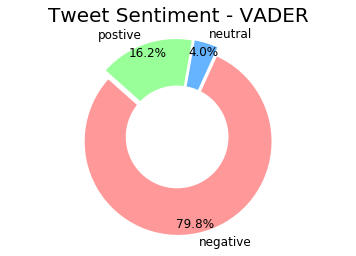

In [25]:
import matplotlib.pyplot as plt
# Pie chart
labels = ['postive','negative','neutral']
sizes = [vad_num_pos,vad_num_neg,vad_num_neu]
colors = ['#99ff99','#ff9999','#66b3ff']
explode = (0.05,0.05,0.05)
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=80, pctdistance=.9, explode = explode,textprops={'fontsize': 12})
#draw circle
centre_circle = plt.Circle((0,0),0.55,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Tweet Sentiment - VADER', size = 20)
plt.axis('equal')  

plt.show()

Analysis on Tweet.csv data set using SentiStrength

In [26]:
#write preprocessed tweets to text file for SentiStrength
pd.DataFrame(list(tweet_dictionary.values())).to_csv('tweet_sentiment.txt', header=None, index=False)

#execute SentiStrength using shell execute %system or !!
!!java -jar SentiStrength.jar sentidata ./SentiStrength/data/ input ./tweet_sentiment.txt

['Finished! Results in: ./tweet_sentiment0_out.txt']

In [27]:
#SentiStrength gives a positive score between +1 and +4 and a negative score between -1 and -4
#read in the SentiStrength results
ssresults=pd.read_csv('tweet_sentiment0_out.txt', delimiter="\t") 
# ssresults

#We add these two columns to our orginal dataframe

tweets['ss_pos']=ssresults['Positive']

tweets['ss_neg']=ssresults['Negative']

#We create a third column for the compound score by Pos - Neg
tweets['ss_comp']=tweets['ss_pos']+tweets['ss_neg']

In [28]:
ss_num_pos= len(tweets[tweets['ss_comp']>0])
ss_num_neg= len(tweets[tweets['ss_comp']<0])
ss_num_neu= len(tweets[(tweets['ss_comp']==0)])

print('According to SentiStrength, there are %d tweets, of which %d are positive and %d are negative while %d tweets are neutral' 
      %(num_tweets,ss_num_pos,ss_num_neg,ss_num_neu))

According to SentiStrength, there are 14640 tweets, of which 4349 are positive and 3026 are negative while 7265 tweets are neutral


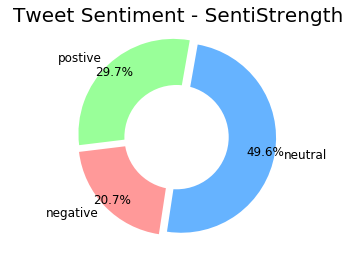

In [29]:
import matplotlib.pyplot as plt
# Pie chart
labels = ['postive','negative','neutral']
sizes = [ss_num_pos,ss_num_neg,ss_num_neu]
colors = ['#99ff99','#ff9999','#66b3ff']
explode = (0.05,0.05,0.05)
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=80, pctdistance=.9, explode = explode,textprops={'fontsize': 12})
#draw circle
centre_circle = plt.Circle((0,0),0.55,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Tweet Sentiment - SentiStrength', size = 20)
plt.axis('equal')  

plt.show()

Distribution from the orginal dataset

In [30]:
org_num_pos= len(tweets[tweets['airline_sentiment']=='positive'])
org_num_neg= len(tweets[tweets['airline_sentiment']=='negative'])
org_num_neu= len(tweets[tweets['airline_sentiment']=='neutral'])

print('According to the orginal dataset, there are %d tweets, of which %d are positive and %d are negative while %d tweets are neutral' 
      %(num_tweets,org_num_pos,org_num_neg,org_num_neu))

According to the orginal dataset, there are 14640 tweets, of which 2363 are positive and 9178 are negative while 3099 tweets are neutral


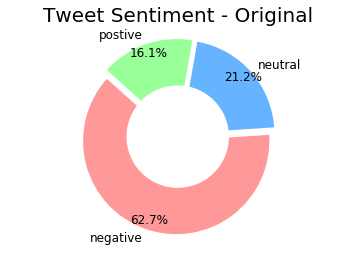

In [31]:
import matplotlib.pyplot as plt
# Pie chart
labels = ['postive','negative','neutral']
sizes = [org_num_pos,org_num_neg,org_num_neu]
colors = ['#99ff99','#ff9999','#66b3ff']
explode = (0.05,0.05,0.05)
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=80, pctdistance=.9, explode = explode,textprops={'fontsize': 12})
#draw circle
centre_circle = plt.Circle((0,0),0.55,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Tweet Sentiment - Original', size = 20)
plt.axis('equal')  

plt.show()

Investigate why there are differences

In [32]:
pd.set_option('max_colwidth', 800)
#dataframe where airline_sentiment doesn't equal vader sentiment doesn't equal sentistrength
#airline positive but not calculated to be positive
investigate_positive= tweets[(tweets['airline_sentiment']=='positive') & (tweets['vader_comp']<.55) & (tweets['ss_comp']<=1)]
investigate_positive[['text','vader_comp','ss_comp']]
    

,text,vader_comp,ss_comp
1,@VirginAmerica plus you've added commercials to the experience... tacky.,0.0000,0
6,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",0.4019,0
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",0.2732,1
13,@VirginAmerica @virginmedia I'm flying your #fabulous #Seductive skies again! U take all the #stress away from travel http://t.co/ahlXHhKiyn,0.1531,1
14,@VirginAmerica Thanks!,0.4404,1
18,I ❤️ flying @VirginAmerica. ☺️👍,0.0000,0
40,"@VirginAmerica View of downtown Los Angeles, the Hollywood Sign, and beyond that rain in the mountains! http://t.co/Dw5nf0ibtr",0.0000,0
45,@VirginAmerica I'm #elevategold for a good reason: you rock!!,0.4404,1
56,@VirginAmerica you know it. Need it on my spotify stat #guiltypleasures,0.0000,-3
81,@VirginAmerica I've applied more then once to be a member of the #inflight crew team...Im 100% interested. #flightattendant #dreampath -G,0.4019,1


# Data Preprocessing for Topic Modeling

In [33]:
#Stopwords

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

for i in range(0,len(tweet_dictionary)):
    tweet_dictionary[i]=remove_stopwords(tweet_dictionary[i])


#Create corupus of all words
words_corpus = []
for i in range(0,len(tweet_dictionary)):
        words_corpus.append([word for word in tweet_dictionary[i].lower().split() if len(word)>3])

dictionary = corpora.Dictionary(words_corpus)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

corpus_bow = [dictionary.doc2bow(text) for text in words_corpus]

#Term Frequency - Inverse Document Frequency

from gensim import corpora, models
tfidf = models.TfidfModel(corpus_bow)
corpus_tfidf = tfidf[corpus_bow]

# Topic Modeling

Topic modeling using TF-IDF

In [38]:
#Only 3 topics this time for simplicity
num_topics = 3
lda_model_tfidf = models.LdaMulticore(corpus_tfidf, num_topics=num_topics, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.023*"thanks" + 0.021*"flight" + 0.011*"hold" + 0.010*"time" + 0.009*"hours" + 0.007*"help" + 0.007*"delayed" + 0.007*"cancelled" + 0.006*"great" + 0.006*"still"
Topic: 1 Word: 0.015*"flight" + 0.008*"flights" + 0.008*"like" + 0.008*"plane" + 0.007*"back" + 0.007*"need" + 0.007*"today" + 0.007*"flying" + 0.007*"help" + 0.007*"cancelled"
Topic: 2 Word: 0.016*"thank" + 0.015*"flight" + 0.012*"service" + 0.011*"please" + 0.009*"cancelled" + 0.008*"customer" + 0.008*"help" + 0.007*"waiting" + 0.007*"plane" + 0.006*"jetblue"


In [39]:
#assign the hightest scoring topic to each tweet
for i in tweets.index:
    tweets.at[i,'topic']=sorted(lda_model_tfidf[corpus_bow[i]], key=lambda tup: -1*tup[1])[0][0]

In [40]:
#plot the sentiment distribution of tweets by topics
def make_chart(positve, negative, neutral,source):
    # Pie chart
    labels = ['postive','negative','neutral']
    sizes = [positve, negative, neutral]
    colors = ['#99ff99','#ff9999','#66b3ff']
    explode = (0.05,0.05,0.05)
    plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=80, pctdistance=.9, explode = explode,textprops={'fontsize': 12})
    #draw circle
    centre_circle = plt.Circle((0,0),0.55,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title('Sentiment Distribution for Topic '+str(source), size = 20)
    plt.axis('equal')  



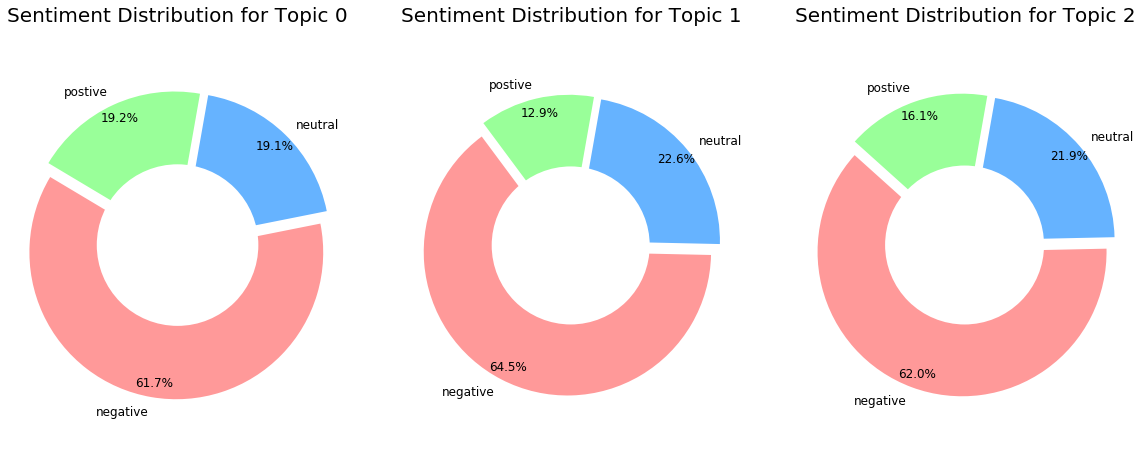

In [41]:
#Some topics are more positive / negative than others
topic=list(range(0,num_topics))
plt.figure(figsize=(20, 8))

for i in topic:
    plt.subplot(1, num_topics, i+1)
    topic_tweets=tweets[tweets['topic']==i]
    num_pos= len(topic_tweets[topic_tweets['airline_sentiment']=='positive'])
    num_neg= len(topic_tweets[topic_tweets['airline_sentiment']=='negative'])
    num_neu= len(topic_tweets[topic_tweets['airline_sentiment']=='neutral'])
    
    make_chart(num_pos,num_neg,num_neu,i)
  


plt.show()